In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# Reading the data

In [2]:
data = pd.read_csv("tuketim.csv",sep = ",",encoding='cp1252')

In [3]:
data.columns = ["date","hour","consumption"]

# Converting the data into a format that I can work with
Date as Timestamp

Hour as integer

Consumption as float

In [4]:
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%d.%m.%Y"))

In [5]:
data["hour"] = data["hour"].apply(lambda x: datetime.strptime(x, "%H:%M").hour)

In [6]:
data["consumption"] = data["consumption"].apply(lambda x: x.replace(".",""))
data["consumption"] = data["consumption"].apply(lambda x: x.replace(",","."))
data["consumption"] = data["consumption"].astype(float)

# Checking for any missing values

In [7]:
flag = 0
for i in data["date"].unique():
    if len(data[data["date"] == i]) != 24:
        print("{} does not have 24 hours of data".format(i))
        flag = 1
if flag == 0:
    print("All days have 24 hours")

All days have 24 hours


In [8]:
flag = 0
for i in data["hour"].unique():
    if len(data[data["hour"] == i]) !=  data["date"].nunique():
        print("There is a problem with hour {}.".format(i))
        print("It has {} values instead of {}".format(len(data[data["hour"] == i]),data["date"].nunique()))
        flag = 1
if flag == 0:
    print("All hours occur the same amount of times")


There is a problem with hour 3.
It has 1796 values instead of 1797
There is a problem with hour 4.
It has 1798 values instead of 1797


We can see that there is a missing hour 3 and extra hour 4.

Since all days have 24 hours, it is easy to see that this error occurs in the same date.

Let's see which day has no occurence of hour 3.

In [9]:
for i in data["date"].unique():
    current_day = data[data["date"] == i]
    if len(current_day[current_day["hour"] == 3]) == 0:
        problem = i
        print("There is a problem with date {}".format(problem))
        

There is a problem with date 2016-03-27T00:00:00.000000000


In [10]:
data[data["date"] == problem]

,date,hour,consumption
2064,2016-03-27,0,27424.42
2065,2016-03-27,1,25949.63
2066,2016-03-27,2,0.00
2067,2016-03-27,4,24776.94
2068,2016-03-27,4,24776.94
2069,2016-03-27,5,24098.97
2070,2016-03-27,6,23267.43
2071,2016-03-27,7,22531.83
2072,2016-03-27,8,23398.59
2073,2016-03-27,9,24969.23


It can be seen that there are 2 occurences of hour4 and no occurence of hour3 on this date.

Also, the previous hour (2) has a consumption value of 0.



In [11]:
data.loc[2066,"consumption"] = (data.loc[2065]["consumption"]+data.loc[2067]["consumption"])/2

In [12]:
data.loc[2067,"hour"] = 3

In [13]:
data[data["date"] == problem]

,date,hour,consumption
2064,2016-03-27,0,27424.420
2065,2016-03-27,1,25949.630
2066,2016-03-27,2,25363.285
2067,2016-03-27,3,24776.940
2068,2016-03-27,4,24776.940
2069,2016-03-27,5,24098.970
2070,2016-03-27,6,23267.430
2071,2016-03-27,7,22531.830
2072,2016-03-27,8,23398.590
2073,2016-03-27,9,24969.230


We handled the problem.

# Creating a function to calculate MAPE of a prediction

In [14]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## FIRST PART
### Using lag168 and lag48 values as naive approaches to predict next day's consumption
#### Test period = 1st of November forwards (including)

In [15]:
data["Lag_168"] = data["consumption"].shift(168)
data["Lag_48"] = data["consumption"].shift(48)

In [16]:
test_start = pd.Timestamp(2020,11,1)

In [17]:
test_start

Timestamp('2020-11-01 00:00:00')

In [18]:
test_data = data[data["date"] >= test_start]

In [19]:
test_data

,date,hour,consumption,Lag_168,Lag_48
42384,2020-11-01,0,28701.62,29481.33,29066.51
42385,2020-11-01,1,27254.15,28002.28,27838.89
42386,2020-11-01,2,26078.57,27115.39,26940.11
42387,2020-11-01,3,25449.47,26415.11,26260.80
42388,2020-11-01,4,25324.01,26075.07,26097.96
...,...,...,...,...,...
43123,2020-12-01,19,40720.16,40895.17,36310.77
43124,2020-12-01,20,39195.74,39240.65,35383.08
43125,2020-12-01,21,38310.79,38366.41,34491.45
43126,2020-12-01,22,37173.97,37446.73,33698.14


In [20]:
Lag_168_mape = MAPE(test_data["consumption"],test_data["Lag_168"])
Lag_48_mape = MAPE(test_data["consumption"],test_data["Lag_48"])

In [21]:
Lag_168_mape

3.449188482612284

In [22]:
Lag_48_mape

8.060314509077509

## SECOND PART
### Using lag168 and lag48 values as features to predict next day's consumption
#### Test period = 1st of November forwards (including)

In [23]:
train_data = data[data["date"] < test_start]

In [24]:
train_data = train_data.dropna()

In [25]:
train_data

,date,hour,consumption,Lag_168,Lag_48
168,2016-01-08,0,28602.02,26277.24,29189.27
169,2016-01-08,1,27112.37,24991.82,27614.02
170,2016-01-08,2,25975.34,23532.61,26578.97
171,2016-01-08,3,25315.55,22464.78,25719.19
172,2016-01-08,4,25128.15,22002.91,25864.63
...,...,...,...,...,...
42379,2020-10-31,19,35265.95,36009.65,34767.13
42380,2020-10-31,20,34178.92,35062.32,33868.97
42381,2020-10-31,21,33240.21,33936.24,32670.05
42382,2020-10-31,22,32159.28,32906.62,31874.30


In [26]:
features = np.asarray(train_data[["Lag_168","Lag_48"]])
values = np.asarray(train_data["consumption"])

In [27]:
model = LinearRegression()

In [28]:
model.fit(features,values)

LinearRegression()

In [29]:
model.coef_

array([0.64390962, 0.30833971])

In [30]:
model.intercept_

1563.773733026217

In [31]:
lr_prediction = model.predict(test_data[["Lag_168","Lag_48"]])

In [32]:
lr_mape = MAPE(test_data["consumption"],lr_prediction)
lr_mape

4.228027341337849

 It is noteworthy that using the combination of Lag_168 and Lag_48 values gives a worse prediction than the Naive approach using Lag_168, however the new prediction is much better than Lag_48 Naive approach.

## THIRD PART
### Using lag168 and lag48 values as features to predict next day's consumption
### Separate regression model for each hour
#### Test period = 1st of November forwards (including)

Let's repeat second part for each hour

In [33]:
coefs = []
intercepts = []
mapes = []

for i in data["hour"].unique():
    
    train = train_data[train_data["hour"] == i]
    test = test_data[test_data["hour"] == i]
    
    features = np.asarray(train[["Lag_168","Lag_48"]])
    values = np.asarray(train["consumption"])
    
    model = LinearRegression()
    model.fit(features,values)
    
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    
    pred = model.predict(test[["Lag_168","Lag_48"]])
    mapes.append(MAPE(test["consumption"],pred))

    
    
    

In [34]:
results = pd.DataFrame(index = np.arange(0,24),columns = ["intercept","coefficients","MAPE"])
results["intercept"] = intercepts
results["coefficients"] = coefs
results["MAPE"] = mapes
print("Average MAPE: {}".format(results["MAPE"].mean()))
display(results)
print("MAPE of these hours are better than the MAPE from part 2: {}".format(list(results[results["MAPE"]<lr_mape].index)))
print("MAPE of these hours are worse than the MAPE from part 2: {}".format(list(results[results["MAPE"]>lr_mape].index)))

Average MAPE: 4.357711083717907


,intercept,coefficients,MAPE
0,2191.320796,"[0.44283593084416456, 0.4868830651080494]",3.262965
1,2120.451986,"[0.4364231903925271, 0.49195523094474414]",3.283087
2,2196.856381,"[0.4257794091603701, 0.4971411372414108]",3.418696
3,2229.136680,"[0.4269401399930502, 0.49279668383745584]",3.202714
4,2204.258151,"[0.44497269964548897, 0.4746859365309408]",3.183023
5,2225.031436,"[0.47845985747756026, 0.43984866493330954]",3.187450
6,2126.946311,"[0.5462000015483184, 0.3759635485430529]",3.148057
7,2310.650658,"[0.6528304559868441, 0.266312594753736]",3.776119
8,3232.765477,"[0.7255429107460375, 0.17372354180037602]",4.672350
9,3594.994097,"[0.720658262094577, 0.17437940556915793]",5.484825


MAPE of these hours are better than the MAPE from part 2: [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 20, 21, 22, 23]
MAPE of these hours are worse than the MAPE from part 2: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


These results show that it is harder to predict the consumption of daytime hours than nighttime hours

## FOURTH PART
### Using lag168 and lag48 values as features to predict next day's consumption
### Separate regression model for each hour
#### Test period = 1st of November forwards (including)

In [35]:
train_data

,date,hour,consumption,Lag_168,Lag_48
168,2016-01-08,0,28602.02,26277.24,29189.27
169,2016-01-08,1,27112.37,24991.82,27614.02
170,2016-01-08,2,25975.34,23532.61,26578.97
171,2016-01-08,3,25315.55,22464.78,25719.19
172,2016-01-08,4,25128.15,22002.91,25864.63
...,...,...,...,...,...
42379,2020-10-31,19,35265.95,36009.65,34767.13
42380,2020-10-31,20,34178.92,35062.32,33868.97
42381,2020-10-31,21,33240.21,33936.24,32670.05
42382,2020-10-31,22,32159.28,32906.62,31874.30


In [36]:
test_data

,date,hour,consumption,Lag_168,Lag_48
42384,2020-11-01,0,28701.62,29481.33,29066.51
42385,2020-11-01,1,27254.15,28002.28,27838.89
42386,2020-11-01,2,26078.57,27115.39,26940.11
42387,2020-11-01,3,25449.47,26415.11,26260.80
42388,2020-11-01,4,25324.01,26075.07,26097.96
...,...,...,...,...,...
43123,2020-12-01,19,40720.16,40895.17,36310.77
43124,2020-12-01,20,39195.74,39240.65,35383.08
43125,2020-12-01,21,38310.79,38366.41,34491.45
43126,2020-12-01,22,37173.97,37446.73,33698.14


In [37]:
data_wide = data[["date","hour","consumption"]]

In [38]:
data_wide = data_wide.pivot(index="date",columns = "hour",values = "consumption")

In [39]:
data_wide.columns = ["hour_" + str(col) for col in data_wide.columns]

In [40]:
data_wide

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,22203.54,21844.16,23094.73,25202.27,...,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09
2016-01-02,26224.60,24708.58,23771.58,22921.29,22870.89,23325.63,23604.98,24022.70,26930.48,30043.60,...,32796.18,32594.55,33358.47,34387.95,33591.26,32648.83,31897.73,31049.20,30906.43,29621.09
2016-01-03,27613.96,25779.28,24566.31,23878.42,23511.38,23672.32,23827.08,23405.11,24638.72,26802.38,...,31056.47,30979.53,32297.46,33462.96,33151.03,32450.21,32093.93,31315.16,31014.19,29462.06
2016-01-04,27103.09,25439.84,24395.07,23961.03,23860.63,24418.47,25708.59,27455.39,32982.07,37175.84,...,39661.98,39211.00,39760.12,39633.29,37621.41,35954.18,35114.12,34066.40,33686.83,31733.54
2016-01-05,29244.38,27637.23,26335.78,25870.23,25975.07,26318.48,27109.29,28570.22,33106.00,36657.12,...,38086.11,37834.89,38599.34,38669.63,36954.78,35306.11,34301.59,33400.82,33359.37,31629.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27,33896.52,31841.72,30897.69,30191.20,29956.10,30199.97,31015.63,32518.79,36129.99,37851.53,...,37205.46,37760.66,39543.01,41895.73,42003.77,40806.68,39426.67,38446.22,37356.91,36119.57
2020-11-28,33935.56,31919.44,30439.27,30020.41,29825.63,29984.86,30444.97,31159.67,33325.74,34868.28,...,35338.14,35645.57,36905.20,39131.92,40203.21,39037.18,38044.69,37128.89,36016.67,34500.14
2020-11-29,32332.68,30410.13,29119.33,28484.61,28150.14,28065.44,28189.16,27883.71,27219.84,27521.40,...,29682.72,30568.06,32342.53,35411.15,36984.04,36310.77,35383.08,34491.45,33698.14,32295.74


In [41]:
data_wide_7 = data[["date","hour","consumption"]]
data_wide_7 = data_wide_7.pivot(index="date",columns = "hour",values = "consumption")
data_wide_7.columns = ["hour_" + str(col) for col in data_wide_7.columns]
data_wide_7 = data_wide_7.reset_index()
data_wide_7 = data_wide_7.rename(columns = {"date" : "Lag7_date"})
data_wide_7 = data_wide_7.set_index("Lag7_date")

In [42]:
data_wide_2 = data[["date","hour","consumption"]]
data_wide_2 = data_wide_2.pivot(index="date",columns = "hour",values = "consumption")
data_wide_2.columns = ["hour_" + str(col) for col in data_wide_2.columns]
data_wide_2 = data_wide_2.reset_index()
data_wide_2 = data_wide_2.rename(columns = {"date" : "Lag2_date"})
data_wide_2 = data_wide_2.set_index("Lag2_date")

In [43]:
data["Lag7_date"] = data["date"].apply(lambda x: x-timedelta(days = 7))
data["Lag2_date"] = data["date"].apply(lambda x: x-timedelta(days = 2))

In [44]:
data

,date,hour,consumption,Lag_168,Lag_48,Lag7_date,Lag2_date
0,2016-01-01,0,26277.24,NaN,NaN,2015-12-25,2015-12-30
1,2016-01-01,1,24991.82,NaN,NaN,2015-12-25,2015-12-30
2,2016-01-01,2,23532.61,NaN,NaN,2015-12-25,2015-12-30
3,2016-01-01,3,22464.78,NaN,NaN,2015-12-25,2015-12-30
4,2016-01-01,4,22002.91,NaN,NaN,2015-12-25,2015-12-30
...,...,...,...,...,...,...,...
43123,2020-12-01,19,40720.16,40895.17,36310.77,2020-11-24,2020-11-29
43124,2020-12-01,20,39195.74,39240.65,35383.08,2020-11-24,2020-11-29
43125,2020-12-01,21,38310.79,38366.41,34491.45,2020-11-24,2020-11-29
43126,2020-12-01,22,37173.97,37446.73,33698.14,2020-11-24,2020-11-29


In [45]:
data_7 = pd.merge(data, data_wide_7, on='Lag7_date', how='left')
data_7 = data_7.drop(["Lag7_date","Lag2_date"],1)

In [46]:
data_2 = pd.merge(data, data_wide_2, on='Lag2_date', how='left')
data_2 = data_2.drop(["Lag7_date","Lag2_date"],1)

In [47]:
data_2

,date,hour,consumption,Lag_168,Lag_48,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2016-01-01,0,26277.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,1,24991.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,2,23532.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,3,22464.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,4,22002.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43123,2020-12-01,19,40720.16,40895.17,36310.77,32332.68,30410.13,29119.33,28484.61,28150.14,...,29682.72,30568.06,32342.53,35411.15,36984.04,36310.77,35383.08,34491.45,33698.14,32295.74
43124,2020-12-01,20,39195.74,39240.65,35383.08,32332.68,30410.13,29119.33,28484.61,28150.14,...,29682.72,30568.06,32342.53,35411.15,36984.04,36310.77,35383.08,34491.45,33698.14,32295.74
43125,2020-12-01,21,38310.79,38366.41,34491.45,32332.68,30410.13,29119.33,28484.61,28150.14,...,29682.72,30568.06,32342.53,35411.15,36984.04,36310.77,35383.08,34491.45,33698.14,32295.74
43126,2020-12-01,22,37173.97,37446.73,33698.14,32332.68,30410.13,29119.33,28484.61,28150.14,...,29682.72,30568.06,32342.53,35411.15,36984.04,36310.77,35383.08,34491.45,33698.14,32295.74


In [48]:
data_7

,date,hour,consumption,Lag_168,Lag_48,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2016-01-01,0,26277.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,1,24991.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,2,23532.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,3,22464.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,4,22002.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43123,2020-12-01,19,40720.16,40895.17,36310.77,33520.81,31518.27,30513.78,29844.1,29650.85,...,37830.17,38656.92,40396.69,42486.34,42255.24,40895.17,39240.65,38366.41,37446.73,36186.83
43124,2020-12-01,20,39195.74,39240.65,35383.08,33520.81,31518.27,30513.78,29844.1,29650.85,...,37830.17,38656.92,40396.69,42486.34,42255.24,40895.17,39240.65,38366.41,37446.73,36186.83
43125,2020-12-01,21,38310.79,38366.41,34491.45,33520.81,31518.27,30513.78,29844.1,29650.85,...,37830.17,38656.92,40396.69,42486.34,42255.24,40895.17,39240.65,38366.41,37446.73,36186.83
43126,2020-12-01,22,37173.97,37446.73,33698.14,33520.81,31518.27,30513.78,29844.1,29650.85,...,37830.17,38656.92,40396.69,42486.34,42255.24,40895.17,39240.65,38366.41,37446.73,36186.83


In [49]:
train_data_2 = data_2[data_2["date"] < test_start]
train_data_2 = train_data_2.dropna()

In [50]:
train_data_7 = data_7[data_7["date"] < test_start]
train_data_7 = train_data_7.dropna()

In [51]:
test_data_2 = data_2[data_2["date"] >= test_start]

In [52]:
test_data_7 = data_7[data_7["date"] >= test_start]

In [53]:
mape = make_scorer(MAPE, greater_is_better=False)

In [54]:
lasso_params = {'alpha':[0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.25, 0.75, 1, 5, 25, 50, 100,150, 200, 300, 500]}
lasso = GridSearchCV(Lasso(), param_grid=lasso_params,cv = 10,scoring = mape,return_train_score = True)

In [55]:
lasso.fit(np.asarray(train_data_2.iloc[:,3:]),np.asarray(train_data_2["consumption"]))

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.25,
                                   0.75, 1, 5, 25, 50, 100, 150, 200, 300,
                                   500]},
             return_train_score=True,
             scoring=make_scorer(MAPE, greater_is_better=False))

In [56]:
lasso.cv_results_["mean_train_score"]

array([-4.41263009, -4.41263007, -4.41263005, -4.41262995, -4.41262985,
       -4.41262961, -4.41262889, -4.41262647, -4.41262526, -4.41260593,
       -4.41250943, -4.4123894 , -4.41214431, -4.41190278, -4.41166398,
       -4.41119245, -4.41027446])

In [57]:
lasso.cv_results_["std_train_score"]

array([0.10521184, 0.10521184, 0.10521183, 0.10521183, 0.10521183,
       0.10521183, 0.10521182, 0.10521178, 0.10521176, 0.10521143,
       0.10520977, 0.10520783, 0.10520526, 0.10520173, 0.1051958 ,
       0.10518033, 0.10517395])

In [58]:
m = lasso.best_estimator_

In [59]:
pred = m.predict(test_data_2.iloc[:,3:])

In [60]:
lasso_mape = MAPE(test_data_2["consumption"],pred)
lasso_mape

3.7730577692999265

In [61]:
def gridCV(train_data,test_data):
    lasso.fit(np.asarray(train_data.iloc[:,3:]),np.asarray(train_data["consumption"]))
    m = lasso.best_estimator_
    pred = m.predict(test_data.iloc[:,3:])
    lasso_mape = MAPE(test_data["consumption"],pred)
    return lasso_mape
    

In [62]:
mapes_2 = {}
for i in range(24):
    train_data_day = train_data_2[train_data_2["hour"] == i]
    test_data_day = test_data_2[test_data_2["hour"] == i]
    mapes_2[i] = gridCV(train_data_day,test_data_day)

In [63]:
mapes_7 = {}
for i in range(24):
    train_data_day = train_data_7[train_data_7["hour"] == i]
    test_data_day = test_data_7[test_data_7["hour"] == i]
    mapes_7[i] = gridCV(train_data_day,test_data_day)

In [64]:
mapes_2

{0: 1.7227150562030966,
 1: 1.8521857840177438,
 2: 1.8061087516518668,
 3: 1.6916192566923696,
 4: 1.7063080582142711,
 5: 1.6578220859365536,
 6: 1.8454593947591753,
 7: 2.2895365632273585,
 8: 3.779430483538667,
 9: 4.704076677830269,
 10: 5.03898306041018,
 11: 5.184482390218935,
 12: 5.438269755129532,
 13: 5.314131706454425,
 14: 5.324970522329706,
 15: 5.00204022174517,
 16: 4.3272056674712625,
 17: 3.432745003367733,
 18: 2.4343531464333186,
 19: 2.3058759973263223,
 20: 2.152573706810608,
 21: 2.1528592971976663,
 22: 2.1364788524539593,
 23: 2.3253716231683503}

In [65]:
mapes_7

{0: 2.3187751915371746,
 1: 2.3356134293153965,
 2: 2.4055439082106544,
 3: 2.1344793937175996,
 4: 2.1614873557261043,
 5: 2.1757526128461744,
 6: 2.316990943487149,
 7: 2.4365890764649802,
 8: 3.190262221949373,
 9: 4.104134683674137,
 10: 4.6248437395411655,
 11: 4.796645023616578,
 12: 4.9516757438562005,
 13: 5.109410874210613,
 14: 4.717990168679073,
 15: 4.186757785165458,
 16: 3.257287285794165,
 17: 2.709085452895936,
 18: 2.0231005396065855,
 19: 1.8770986240466137,
 20: 1.953702023074413,
 21: 1.9943715632428243,
 22: 1.849475407817716,
 23: 2.104225790571026}

In [145]:
mapes_27 = pd.DataFrame(index = mapes_2.keys(), columns = ["2","7"])

In [148]:
mapes_27["2"] = mapes_2.values()
mapes_27["7"] = mapes_7.values()

<AxesSubplot:>

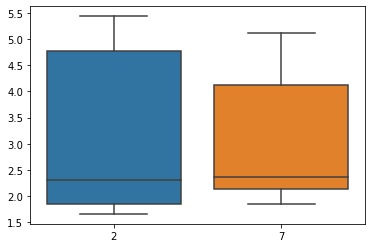

In [149]:
sns.boxplot(data = mapes_27)

In [156]:
print("These are the hours lag2 model performed better: ")
display(mapes_27[mapes_27["2"]>mapes_27["7"]])

These are the hours lag2 model performed better: 


,2,7
8,3.779430,3.190262
9,4.704077,4.104135
10,5.038983,4.624844
11,5.184482,4.796645
12,5.438270,4.951676
13,5.314132,5.109411
14,5.324971,4.717990
15,5.002040,4.186758
16,4.327206,3.257287
17,3.432745,2.709085


In [157]:
print("These are the hours lag7 model performed better: ")
display(mapes_27[mapes_27["2"]<mapes_27["7"]])

These are the hours lag7 model performed better: 


,2,7
0,1.722715,2.318775
1,1.852186,2.335613
2,1.806109,2.405544
3,1.691619,2.134479
4,1.706308,2.161487
5,1.657822,2.175753
6,1.845459,2.316991
7,2.289537,2.436589


As it can be seen, the best results were obtained by 2 day lag model, however, overall accuracy of the models are similar. 

In [ ]:
### HAVENT FINISHED THE LAST PARTS, WILL UPLOAD TOMORROW

In [93]:
X_train = np.asarray(train_data_7.iloc[:,3:])

In [94]:
Y_train = np.asarray(train_data_7["consumption"])

In [91]:
X_test = np.asarray(test_data_7.iloc[:,3:])

In [92]:
Y_test = np.asarray(test_data_7["consumption"]) 

In [159]:
X_train.shape

(42216, 26)

In [161]:
Y_train.shape

(42216,)

In [160]:
X_test.shape

(744, 26)

In [163]:
Y_test.shape

(744,)

In [111]:
def loss_fn(X, Y, beta):
    return cp.pnorm(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def new_loss(l1, beta):
    total = 0
    for i in range(2,beta.shape[0]):
        total+= beta[i]-beta[i-1]
    return l1*total
        
def objective_fn(X, Y, beta, l1, l2):
    return loss_fn(X, Y, beta) + l2 * regularizer(beta) + new_loss(l1, beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value



In [113]:
beta = cp.Variable(26)
l1 = cp.Parameter(nonneg=True)
l2 = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, l1, l2)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    l1.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

ParameterError: A Parameter (whose name is 'param210') does not have a value associated with it; all Parameter objects must have values before solving a problem.

# FINAL PART
### Comparison of the results

In [126]:
part3 = results["MAPE"]
part4_2 = mapes_2.values()
part4_7 = mapes_7.values()

In [133]:
DF = pd.DataFrame(index = np.arange(0,24),columns = ["part1_48","part1_168","part2","part3","part4_2day","part4_7day"])

In [134]:
DF["part1_48"] = Lag_48_mape
DF["part1_168"] = Lag_168_mape
DF["part2"] = lr_mape
DF["part3"] = part3
DF["part4_2day"] = part4_2
DF["part4_7day"] = part4_7

In [135]:
DF

,part1_48,part1_168,part2,part3,part4_2day,part4_7day
0,8.060315,3.449188,4.228027,3.262965,1.722715,2.318775
1,8.060315,3.449188,4.228027,3.283087,1.852186,2.335613
2,8.060315,3.449188,4.228027,3.418696,1.806109,2.405544
3,8.060315,3.449188,4.228027,3.202714,1.691619,2.134479
4,8.060315,3.449188,4.228027,3.183023,1.706308,2.161487
5,8.060315,3.449188,4.228027,3.187450,1.657822,2.175753
6,8.060315,3.449188,4.228027,3.148057,1.845459,2.316991
7,8.060315,3.449188,4.228027,3.776119,2.289537,2.436589
8,8.060315,3.449188,4.228027,4.672350,3.779430,3.190262
9,8.060315,3.449188,4.228027,5.484825,4.704077,4.104135


<AxesSubplot:>

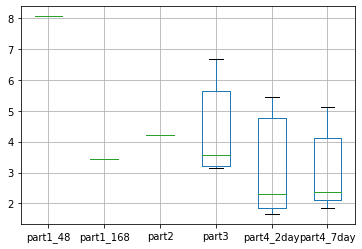

In [136]:
DF.boxplot()

<AxesSubplot:>

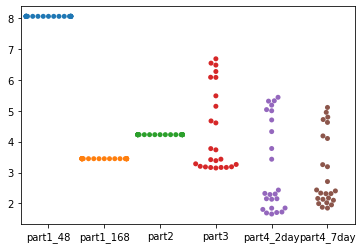

In [143]:
sns.swarmplot(data = DF )

It can be seen that the solution in part 4 gave the best results. The best MAPE values are found by a 2 day lag, however, using 7 day lag gives MAPE values that are close together with less standard deviation.